In [48]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [49]:
# Load and preprocess the Digits dataset
digits = load_digits()
X = digits.data
y_true = digits.target

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Dataset shape: {X_scaled.shape}")
print(f"Number of classes: {len(np.unique(y_true))}")


Dataset shape: (1797, 64)
Number of classes: 10


In [50]:
# Define the Clustering Accuracy (ACC) using the Hungarian algorithm
def clustering_accuracy(y_true, y_pred):
    """
    Calculate clustering accuracy using the Hungarian algorithm.
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    return sum([w[i, j] for i, j in zip(*ind)]) / y_pred.size


In [51]:
# Alternatively, if sklearn.utils.linear_assignment_ is deprecated, use scipy
from sklearn.metrics import confusion_matrix

def clustering_accuracy(y_true, y_pred):
    """
    Compute clustering accuracy using the Hungarian algorithm.
    """
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)
    total_correct = cm[row_ind, col_ind].sum()
    return total_correct / y_true.size


In [52]:
# Initialize a DataFrame to store the results
results = pd.DataFrame(columns=['Algorithm', 'NMI', 'ARI', 'ACC'])

# Define a function to evaluate clustering performance
def evaluate_clustering(y_true, y_pred, algorithm_name):
    nmi = normalized_mutual_info_score(y_true, y_pred)
    ari = adjusted_rand_score(y_true, y_pred)
    acc = clustering_accuracy(y_true, y_pred)
    results.loc[len(results)] = [algorithm_name, nmi, ari, acc]
    print(f"{algorithm_name} -- NMI: {nmi:.4f}, ARI: {ari:.4f}, ACC: {acc:.4f}")


In [53]:
# Baseline 1: K-Means Clustering
kmeans = KMeans(n_clusters=10, random_state=RANDOM_STATE)
y_kmeans = kmeans.fit_predict(X_scaled)
evaluate_clustering(y_true, y_kmeans, 'K-Means')


K-Means -- NMI: 0.6720, ARI: 0.5305, ACC: 0.6661


In [54]:
# Baseline 2: Spectral Clustering
spectral = SpectralClustering(
    n_clusters=10,
    affinity='nearest_neighbors',
    n_neighbors=10,  # Adjust based on data
    eigen_solver='arpack',  # Alternative: 'lobpcg'
    assign_labels='kmeans',
    random_state=RANDOM_STATE,
    n_init=10
)

try:
    y_spectral = spectral.fit_predict(X_scaled)
    evaluate_clustering(y_true, y_spectral, 'Spectral Clustering')
except Exception as e:
    print(f"Spectral Clustering failed: {e}")


Spectral Clustering -- NMI: 0.8282, ARI: 0.7067, ACC: 0.7813


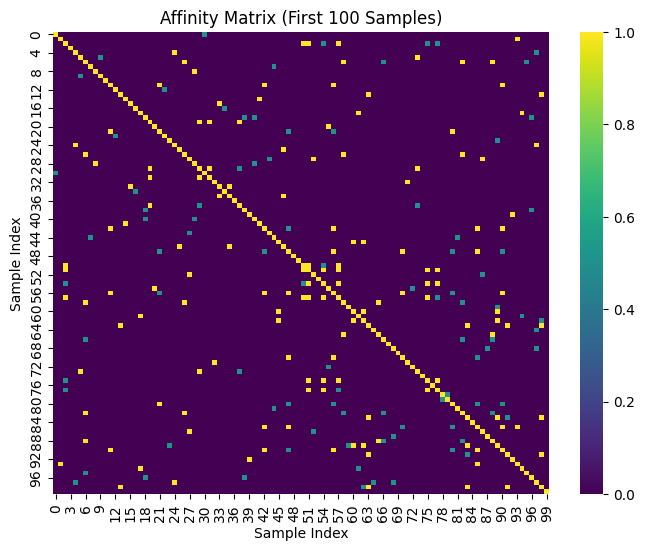

In [55]:
from sklearn.neighbors import kneighbors_graph

# Compute the affinity matrix using nearest neighbors
affinity_matrix = kneighbors_graph(X_scaled, n_neighbors=10, include_self=True)
affinity_matrix = 0.5 * (affinity_matrix + affinity_matrix.T)  # Make symmetric

# Visualize a subset of the affinity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(affinity_matrix.toarray()[:100, :100], cmap='viridis')
plt.title('Affinity Matrix (First 100 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Sample Index')
plt.show()


In [56]:
# Baseline 3: Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=10, linkage='ward')
y_agglo = agglo.fit_predict(X_scaled)
evaluate_clustering(y_true, y_agglo, 'Agglomerative Clustering')


Agglomerative Clustering -- NMI: 0.7956, ARI: 0.6643, ACC: 0.7451


In [57]:
# Baseline 4: Gaussian Mixture Models
gmm = GaussianMixture(n_components=10, random_state=RANDOM_STATE)
y_gmm = gmm.fit_predict(X_scaled)
evaluate_clustering(y_true, y_gmm, 'Gaussian Mixture Model')


Gaussian Mixture Model -- NMI: 0.6902, ARI: 0.5467, ACC: 0.6694


In [58]:
# Baseline 5: DBSCAN (optional, since it's not necessarily optimal for this dataset)
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=5, min_samples=5)
y_dbscan = dbscan.fit_predict(X_scaled)

# Handle noise points (-1 labels)
# For ACC, assign noise points to a new cluster or the most frequent cluster
# Here, we'll assign them to a separate cluster
y_dbscan_adjusted = y_dbscan.copy()
y_dbscan_adjusted[y_dbscan == -1] = 10  # Assuming labels 0-9 are used

evaluate_clustering(y_true, y_dbscan_adjusted, 'DBSCAN')


DBSCAN -- NMI: 0.0473, ARI: 0.0025, ACC: 0.1341


In [59]:
# Display the results
results


,Algorithm,NMI,ARI,ACC
0,K-Means,0.672025,0.530512,0.666110
1,Spectral Clustering,0.828247,0.706697,0.781302
2,Agglomerative Clustering,0.795587,0.664346,0.745131
3,Gaussian Mixture Model,0.690155,0.546745,0.669449
4,DBSCAN,0.047344,0.002478,0.134112


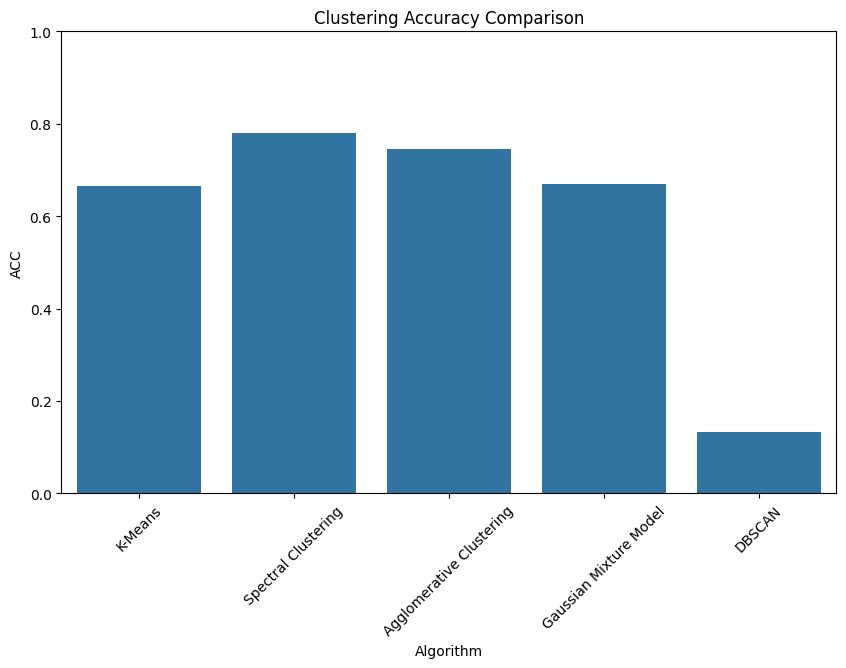

In [60]:
# Visualize the results
plt.figure(figsize=(10, 6))
sns.barplot(x='Algorithm', y='ACC', data=results)
plt.title('Clustering Accuracy Comparison')
plt.ylabel('ACC')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


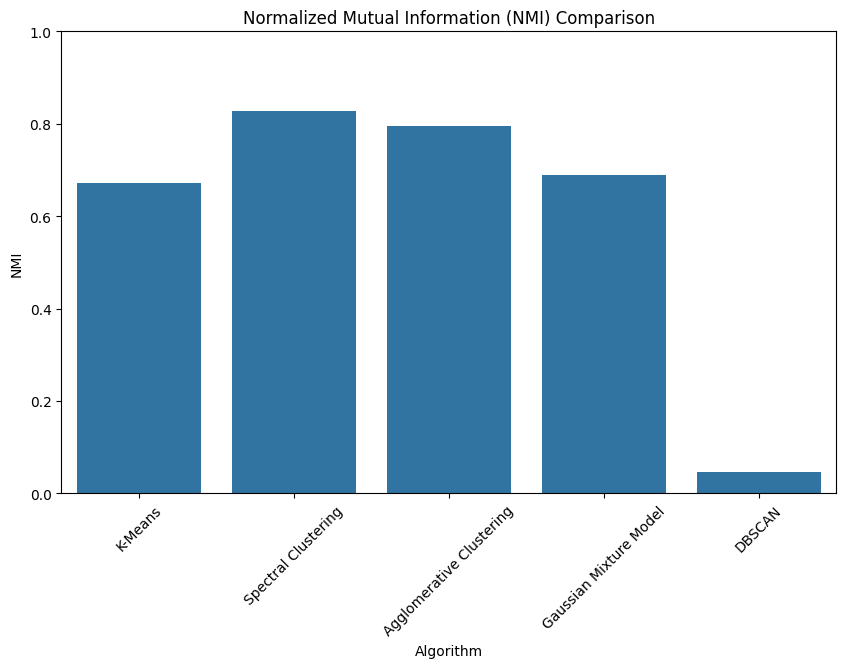

In [61]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Algorithm', y='NMI', data=results)
plt.title('Normalized Mutual Information (NMI) Comparison')
plt.ylabel('NMI')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


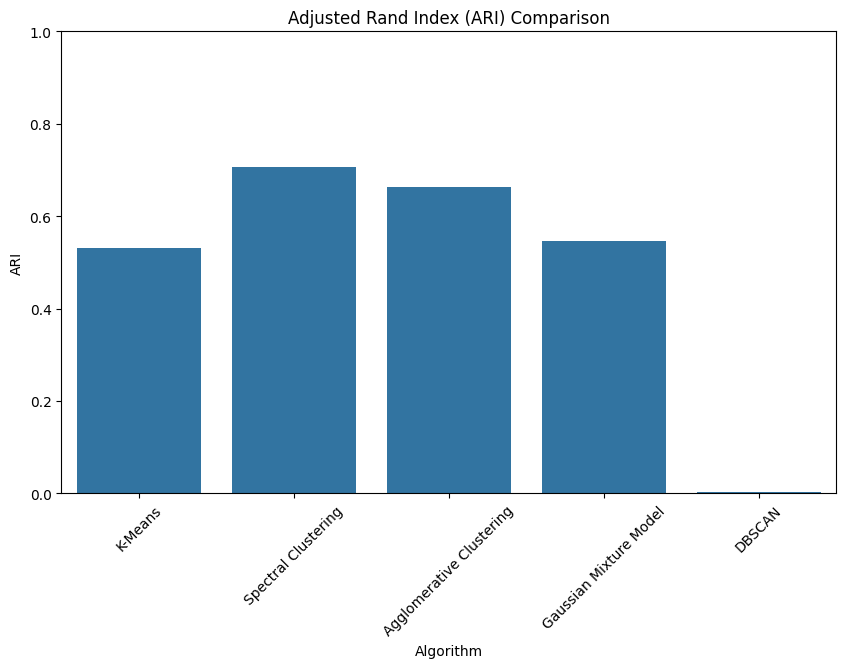

In [62]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Algorithm', y='ARI', data=results)
plt.title('Adjusted Rand Index (ARI) Comparison')
plt.ylabel('ARI')
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.show()


In [63]:
# Summary of the Baselines
print("Baseline Clustering Performance on Digits Dataset:")
display(results)


Baseline Clustering Performance on Digits Dataset:


,Algorithm,NMI,ARI,ACC
0,K-Means,0.672025,0.530512,0.666110
1,Spectral Clustering,0.828247,0.706697,0.781302
2,Agglomerative Clustering,0.795587,0.664346,0.745131
3,Gaussian Mixture Model,0.690155,0.546745,0.669449
4,DBSCAN,0.047344,0.002478,0.134112


# References

- [Scikit-learn Clustering Documentation](https://scikit-learn.org/stable/modules/clustering.html)
- [Hungarian Algorithm (Linear Assignment Problem)](https://en.wikipedia.org/wiki/Hungarian_algorithm)
- [Adjusted Rand Index](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html)
- [Normalized Mutual Information](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html)
